<a href="https://colab.research.google.com/github/AlexMontgomerie/deepLearning/blob/master/denoise_additive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
#!rm -rf deepLearning
!git clone https://github.com/AlexMontgomerie/deepLearning
%cd deepLearning
!git pull origin master
!pip install gputil
!pip install psutil
!pip install humanize
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

/content
Cloning into 'deepLearning'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 366 (delta 61), reused 49 (delta 20), pack-reused 245
Receiving objects: 100% (366/366), 150.67 MiB | 11.23 MiB/s, done.
Resolving deltas: 100% (144/144), done.
Checking out files: 100% (106/106), done.
/content/deepLearning
From https://github.com/AlexMontgomerie/deepLearning
 * branch            master     -> FETCH_HEAD
Already up to date.
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
('RAM Free: 12.9 GB', ' | Proc size: 152.7 MB')
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [12]:
from common import *
!chmod +x setup.sh
!./setup.sh

--2019-03-12 13:05:23--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 103.116.4.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|103.116.4.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-12 13:05:24--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-12 13:05:24--  https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.box.co

In [13]:
from denoise_network import *
from get_data import get_data

EPOCHS = 50

seqs_train, seqs_test = get_data()

# get traning data

denoise_generator     = DenoiseHPatches(seqs_train, batch_size=500)
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=500)

100%|██████████| 40/40 [00:42<00:00,  1.04it/s]


In [0]:

import sys
import json
import os
import glob
import keras
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, UpSampling2D, concatenate, Subtract
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
import matplotlib.pyplot as plt

def get_denoise_model_additive(shape):

  inputs  = Input(shape)
  depth1  = 16
  conv1_1 = Conv2D(depth1, 1, padding = 'same', kernel_initializer = 'he_normal', name='denoise_in')(inputs)
  
  # convolution layers
  conv1_2  = Conv2D(depth1, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_2' )(conv1_1)
  conv1_3  = Conv2D(depth1, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_3' )(conv1_1)
  conv1_5  = Conv2D(depth1, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_5' )(conv1_1)
  conv1_7  = Conv2D(depth1, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_7' )(conv1_1)
  conv1_9  = Conv2D(depth1, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_9' )(conv1_1)
  conv1_11 = Conv2D(depth1, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_11')(conv1_1)
  
  # network
  net1 = Subtract()([conv1_1, conv1_2])
  net1 = BatchNormalization()(net1)
  net1 = Subtract()([conv1_1, conv1_3])
  net1 = BatchNormalization()(net1)
  net1 = Subtract()([conv1_1, conv1_5])
  net1 = BatchNormalization()(net1)
  net1 = Subtract()([conv1_1, conv1_7])
  net1 = BatchNormalization()(net1)
  net1 = Subtract()([conv1_1, conv1_9])
  net1 = BatchNormalization()(net1)
  net1 = Subtract()([conv1_1, conv1_11])
  net1 = BatchNormalization()(net1)  
  
  # convolution layers
  depth2 = 16
  #conv2_1  = Conv2D(depth2, 1, padding = 'same', kernel_initializer = 'he_normal')(net1)
  conv2_2  = Conv2D(depth2, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_2' )(net1)
  conv2_3  = Conv2D(depth2, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_3' )(net1)
  conv2_5  = Conv2D(depth2, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_5' )(net1)
  conv2_7  = Conv2D(depth2, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_7' )(net1)
  conv2_9  = Conv2D(depth2, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_9' )(net1)
  conv2_11 = Conv2D(depth2, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_11')(net1)
  
  # network
  net2 = Subtract()([net1, conv2_2])
  net2 = BatchNormalization()(net2)
  net2 = Subtract()([net1, conv2_3])
  net2 = BatchNormalization()(net2)
  net2 = Subtract()([net1, conv2_5])
  net2 = BatchNormalization()(net2)
  net2 = Subtract()([net1, conv2_7])
  net2 = BatchNormalization()(net2)
  net2 = Subtract()([net1, conv2_9])
  net2 = BatchNormalization()(net2)
  net2 = Subtract()([net1, conv2_11])
  net2 = BatchNormalization()(net2)  
  
  # convolution layers
  depth3 = 16
  #conv3_1  = Conv2D(depth3, 1, padding = 'same', kernel_initializer = 'he_normal')(net1)
  conv3_2  = Conv2D(depth3, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_2' )(net2)
  conv3_3  = Conv2D(depth3, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_3' )(net2)
  conv3_5  = Conv2D(depth3, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_5' )(net2)
  conv3_7  = Conv2D(depth3, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_7' )(net2)
  conv3_9  = Conv2D(depth3, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_9' )(net2)
  conv3_11 = Conv2D(depth3, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_11')(net2)
  
  # network
  net3 = Subtract()([net2, conv3_2])
  net3 = BatchNormalization()(net3)
  net3 = Subtract()([net2, conv3_3])
  net3 = BatchNormalization()(net3)
  net3 = Subtract()([net2, conv3_5])
  net3 = BatchNormalization()(net3)
  net3 = Subtract()([net2, conv3_7])
  net3 = BatchNormalization()(net3)
  net3 = Subtract()([net2, conv3_9])
  net3 = BatchNormalization()(net3)
  net3 = Subtract()([net2, conv3_11])
  net3 = BatchNormalization()(net3)  
  
  net = Conv2D(1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_out' )(net3)
  
  return Model(inputs = inputs, outputs = net)

# optimiser
opt  = opt = keras.optimizers.nadam()

# train network
def ssim_loss(clean,noisy):
  return 1 - tf.image.ssim(clean, noisy, max_val=1.0)

def snr_loss(clean,noisy):
  tmp = tf.image.psnr(clean, noisy, max_val=1.0)
  print(tmp)
  return - tmp

In [7]:
# get model
shape = (32, 32, 1)
denoise_model = get_denoise_model_additive(shape)

# callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 3, mode= 'auto'),
    keras.callbacks.ModelCheckpoint('data/denoise_model_mae.weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
]

denoise_model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['accuracy'])
denoise_history = denoise_model.fit_generator(generator=denoise_generator, epochs=EPOCHS, callbacks=callbacks,
                                              verbose=1, validation_data=denoise_generator_val)

Epoch 1/50


AttributeError: ignored

In [0]:
plot_denoise(denoise_model)
plt.plot(denoise_history.history['loss'])
plt.plot(denoise_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [15]:
# get model
shape = (32, 32, 1)
denoise_model = get_denoise_model_additive(shape)

# callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 3, mode= 'auto'),
    keras.callbacks.ModelCheckpoint('data/denoise_model_ssim.weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
]

denoise_model.compile(loss=ssim_loss, optimizer=opt, metrics=['accuracy'])
denoise_history = denoise_model.fit_generator(generator=denoise_generator, epochs=EPOCHS, callbacks=callbacks,
                                              verbose=1, validation_data=denoise_generator_val)

Epoch 1/50
3117/3117 [==============================] - 598s 192ms/step - loss: 0.4134 - acc: 0.0277 - val_loss: 0.3494 - val_acc: 0.0467

Epoch 00001: val_loss improved from inf to 0.34938, saving model to data/denoise_model_ssim.weights.01-0.35.hdf5
Epoch 2/50
3117/3117 [==============================] - 586s 188ms/step - loss: 0.3102 - acc: 0.0490 - val_loss: 0.3193 - val_acc: 0.0515

Epoch 00002: val_loss improved from 0.34938 to 0.31925, saving model to data/denoise_model_ssim.weights.02-0.32.hdf5
Epoch 3/50
3117/3117 [==============================] - 587s 188ms/step - loss: 0.2965 - acc: 0.0502 - val_loss: 0.3241 - val_acc: 0.0561

Epoch 00003: val_loss did not improve from 0.31925
Epoch 4/50
3117/3117 [==============================] - 588s 189ms/step - loss: 0.2934 - acc: 0.0508 - val_loss: 0.3082 - val_acc: 0.0599

Epoch 00004: val_loss improved from 0.31925 to 0.30824, saving model to data/denoise_model_ssim.weights.04-0.31.hdf5
Epoch 5/50
3117/3117 [========================

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


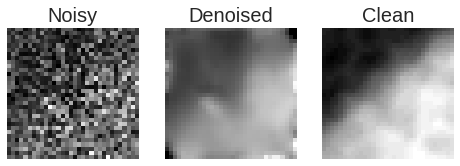

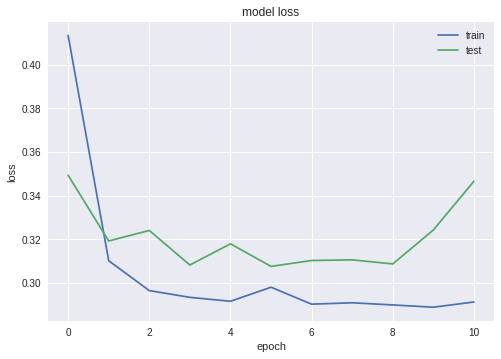

In [16]:
plot_denoise(denoise_model)
plt.plot(denoise_history.history['loss'])
plt.plot(denoise_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [17]:
# get model
shape = (32, 32, 1)
denoise_model = get_denoise_model_additive(shape)

# callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 3, mode= 'auto'),
    keras.callbacks.ModelCheckpoint('data/denoise_model_snr.weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
]

denoise_model.compile(loss=snr_loss, optimizer=opt, metrics=['accuracy'])
denoise_history = denoise_model.fit_generator(generator=denoise_generator, epochs=EPOCHS, callbacks=callbacks,
                                              verbose=1, validation_data=denoise_generator_val)

Tensor("loss_5/denoise_out_loss/PSNR/Identity_3:0", shape=(?,), dtype=float32)
Epoch 1/50
3117/3117 [==============================] - 557s 179ms/step - loss: 19.6914 - acc: 0.0520 - val_loss: 17.2019 - val_acc: 0.0643

Epoch 00001: val_loss improved from inf to 17.20194, saving model to data/denoise_model_snr.weights.01-17.20.hdf5
Epoch 2/50
3117/3117 [==============================] - 553s 177ms/step - loss: 17.6483 - acc: 0.0594 - val_loss: 17.0914 - val_acc: 0.0658

Epoch 00002: val_loss improved from 17.20194 to 17.09138, saving model to data/denoise_model_snr.weights.02-17.09.hdf5
Epoch 3/50
3117/3117 [==============================] - 546s 175ms/step - loss: 17.4076 - acc: 0.0615 - val_loss: 16.7521 - val_acc: 0.0670

Epoch 00003: val_loss improved from 17.09138 to 16.75214, saving model to data/denoise_model_snr.weights.03-16.75.hdf5
Epoch 4/50
3117/3117 [==============================] - 546s 175ms/step - loss: 17.0219 - acc: 0.0647 - val_loss: 16.3945 - val_acc: 0.0721

Epoch

100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


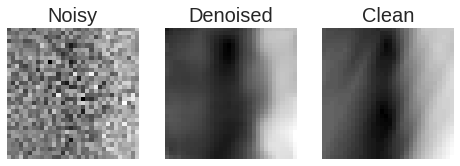

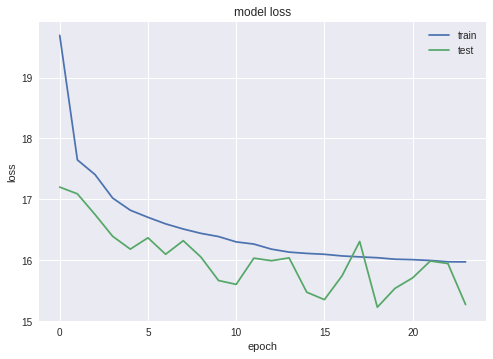

In [18]:
plot_denoise(denoise_model)
plt.plot(denoise_history.history['loss'])
plt.plot(denoise_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
import sys
import json
import os
import glob
import keras
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, UpSampling2D, concatenate
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
import matplotlib.pyplot as plt


def get_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))

  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model
  
  

In [0]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs))

### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    use_clean=True)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000)

Using clean patches
100%|██████████| 116/116 [00:37<00:00,  2.63it/s]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(0, 0)
(1, 1)
(2, 2)
(3, 3)
(4, 4)
(5, 5)
(6, 6)
(7, 7)
(8, 8)
(9, 9)
(10, 10)
(11, 11)
(12, 12)
(13, 13)
(14, 14)
(15, 15)
(16, 16)
(17, 17)
(18, 18)
(19, 19)
(20, 20)
(21, 21)
(22, 22)
(23, 23)
(24, 24)
(25, 25)
(26, 26)
(27, 27)
(28, 28)
(29, 29)
(30, 30)
(31, 31)
(32, 32)
(33, 33)
(34, 34)
(35, 35)
(36, 36)
(37, 37)
(38, 38)
(39, 39)
(40, 40)
(41, 41)
(42, 42)
(43, 43)
(44, 44)
(45, 45)
(46, 46)
(47, 47)
(48, 48)
(49, 49)
(50, 50)
(51, 51)
(52, 52)
(53, 53)
(54, 54)
(55, 55)
(56, 56)
(57, 57)
(58, 58)
(59, 59)
(60, 60)
(61, 61)
(62, 62)
(63, 63)
(64, 64)
(65, 65)
(66, 66)
(67, 67)
(68, 68)
(69, 69)
(70, 70)
(71, 71)
(72, 72)
(73, 73)
(74, 74)
(75, 75)
(76, 76)
(77, 77)
(78, 78)
(79, 79)
(80, 80)
(81, 81)
(82, 82)
(83, 83)
(84, 84)
(85, 85)
(86, 86)
(87, 87)
(88, 88)
(89, 89)
(90, 90)
(91, 91)
(92, 92)
(93, 93)
(94, 94)
(95, 95)
(96, 96)
(97, 97)
(98, 98)
(99, 99)
(100, 100)
(101, 101)
(102, 102)
(103, 103)
(104, 104)
(105, 105)
(106, 106)
(107, 107)
(108, 108)
(109, 109)
(110, 110)